In [2]:
!pip install pandas matplotlib seaborn numpy scipy


  Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.14.1-cp313-cp313-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl (11.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 13.0 MB/s eta 0:00:0000:0100:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scipy-1.14.1-cp313-cp313-macosx_14_0_arm64.whl (23.1 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━

RTT Data:
   Iteration     Region       RTT
0          1  Bangalore  0.049336
1          1      Assam  0.147073
2          2  Bangalore  0.049214
3          2      Assam  0.061597
4          3  Bangalore  0.049308

Pivoted RTT Data:
   Iteration  RTT_Assam  RTT_Bangalore
0          1   0.147073       0.049336
1          2   0.061597       0.049214
2          3   0.061859       0.049308
3          4   0.089171       0.098027
4          5   0.063816       0.049575

95th Percentile Thresholds:
RTT_Bangalore: 0.30263
RTT_Assam: 0.23851165000000035


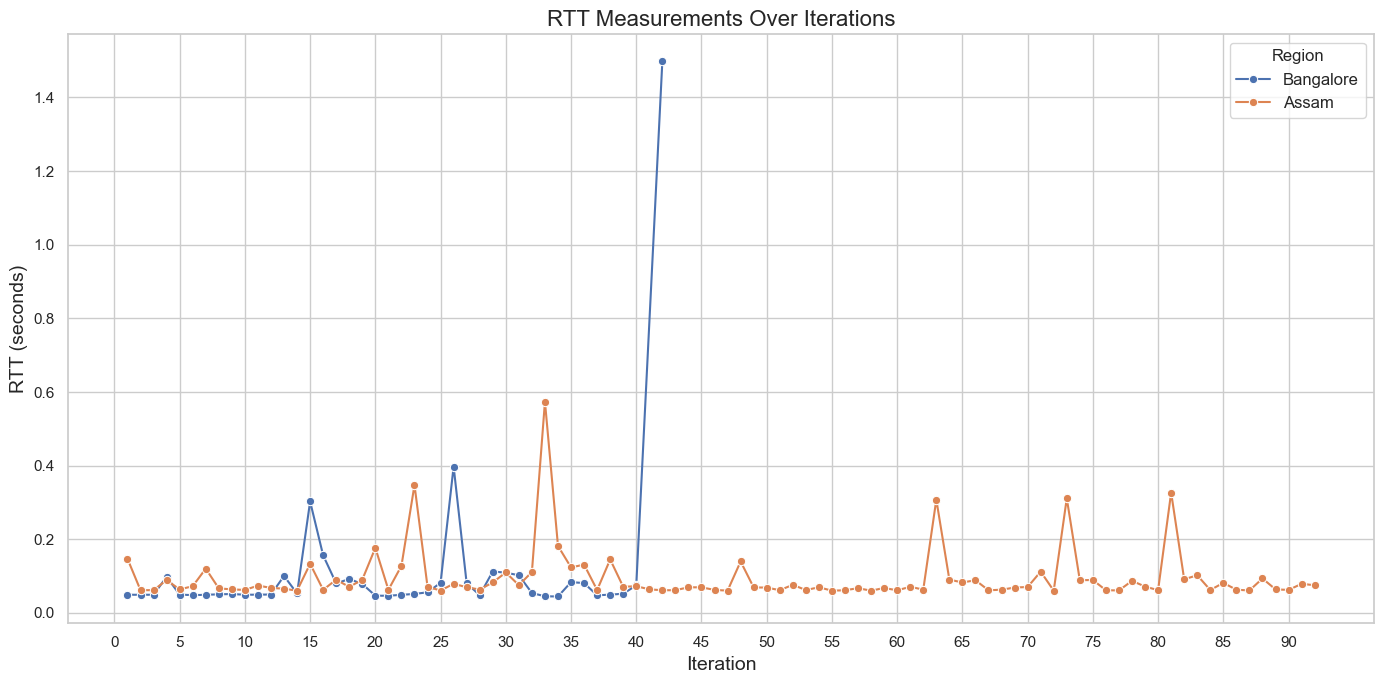

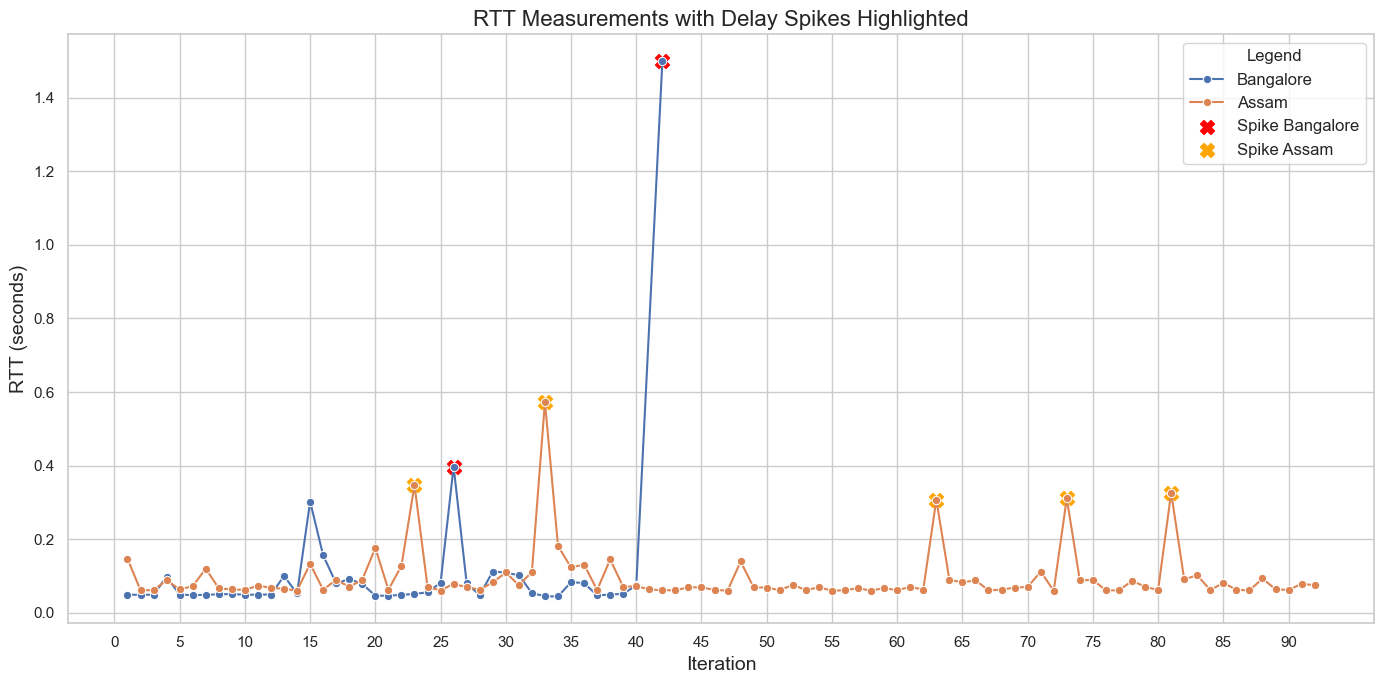

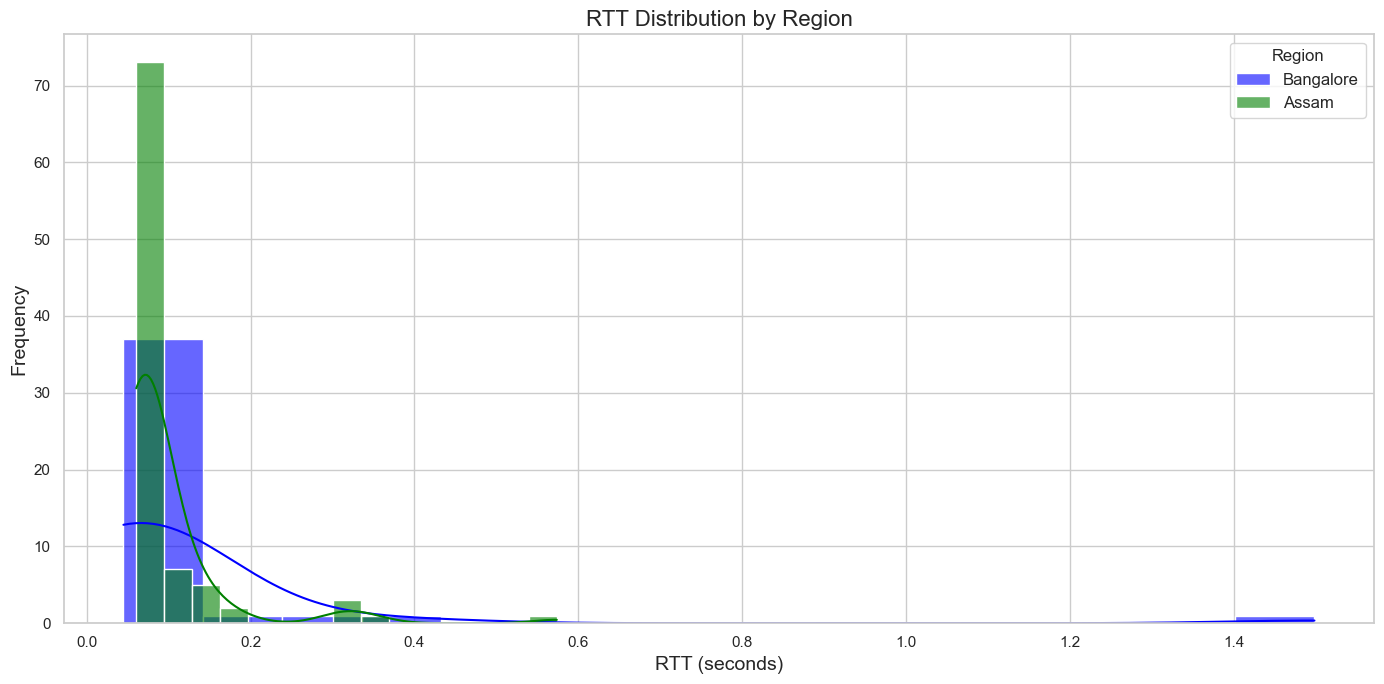

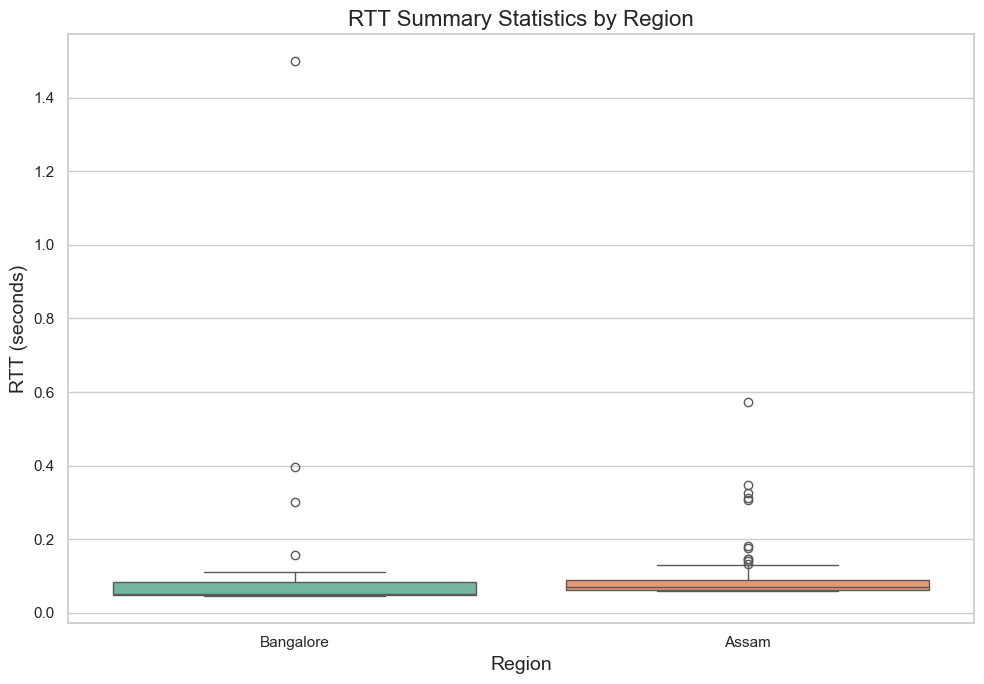

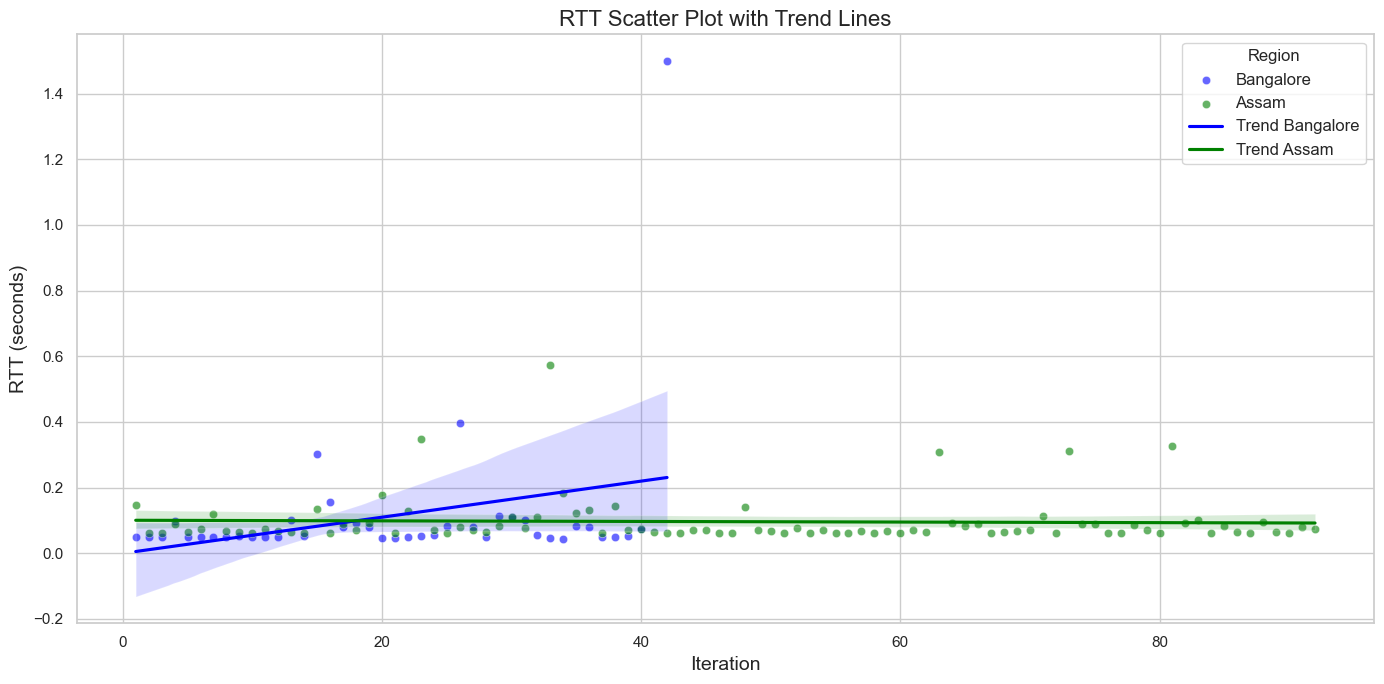

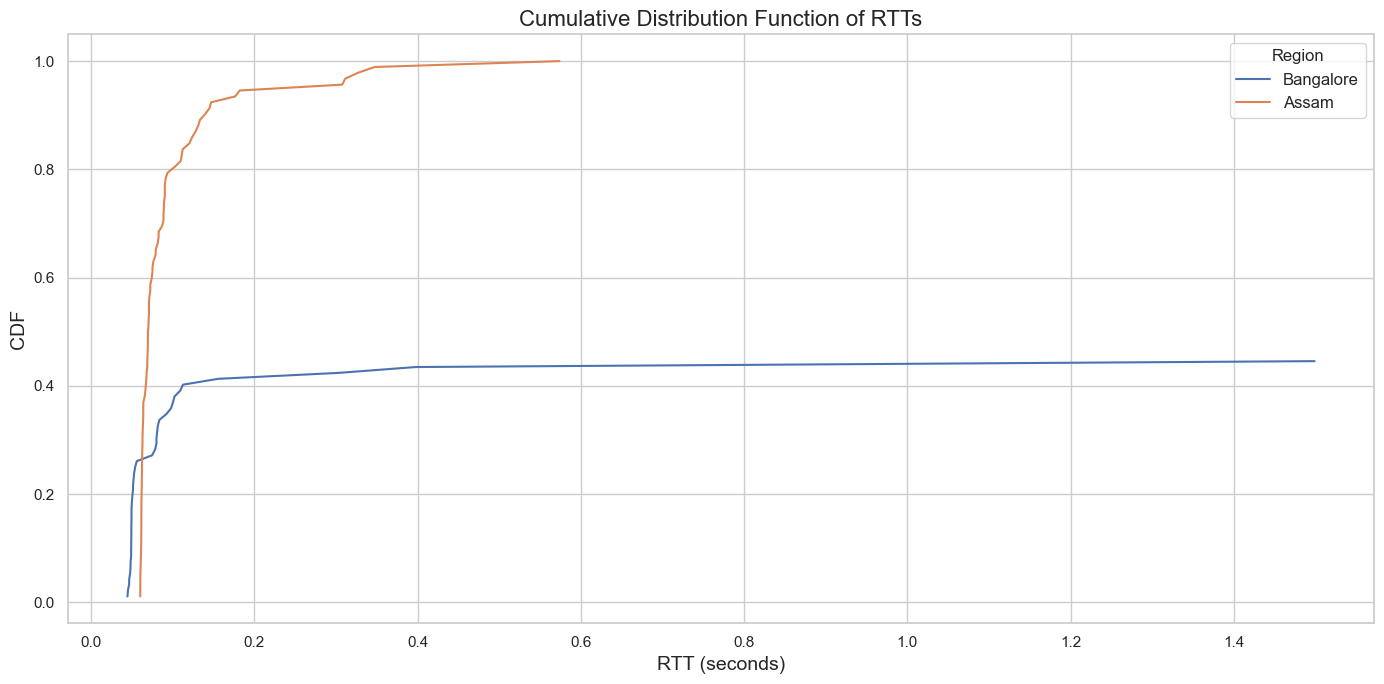


Descriptive Statistics:
       RTT_Bangalore  RTT_Assam
count      41.000000  92.000000
mean        0.115117   0.096009
std         0.231536   0.075521
min         0.044621   0.060288
25%         0.049308   0.062440
50%         0.052122   0.070022
75%         0.083645   0.090344
95%         0.302630   0.238512
max         1.498802   0.573772

Number of Delay Spikes per Region:
Spike_Bangalore    2
Spike_Assam        5
dtype: int64


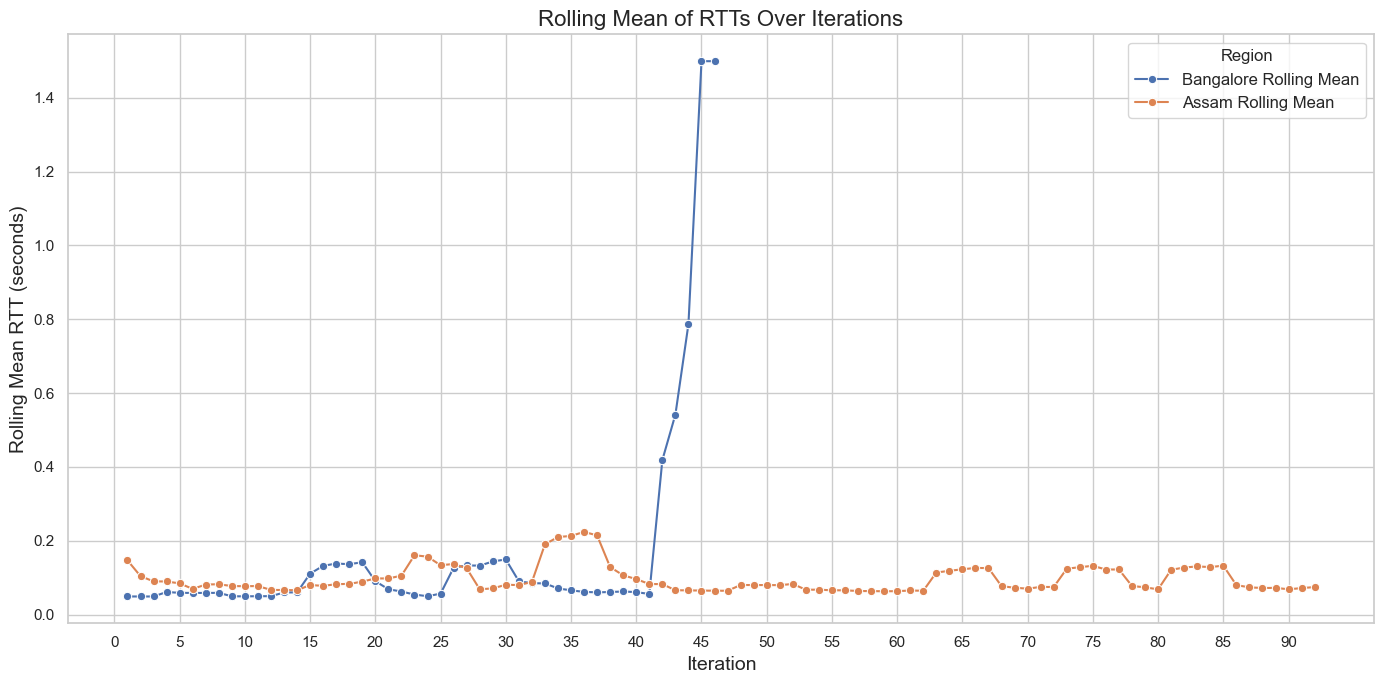

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# 1. Data Preparation

# Define the path to your RTT data file
data_file_path = 'rtt_store.txt'  # Replace with your actual file path

# Read the RTT data from the text file
with open(data_file_path, 'r') as file:
    raw_data = file.read()

# Initialize lists to store parsed data
iterations = []
regions = []
rtts = []

# Define the regex pattern to extract data
# Assuming server1 is Bangalore, server2 is Delhi (though not present in data), server3 is Assam
pattern = r"Iteration\s+(\d+),\s+Verifier\s+server(\d+):\s+RTT=([0-9.]+)"

# Mapping of server numbers to regions
server_mapping = {
    '1': 'Bangalore',
    '2': 'Delhi',    # Assuming server2 represents Delhi user, though not present in data
    '3': 'Assam'
}

# Parse each line using regex
for line in raw_data.strip().split('\n'):
    match = re.match(pattern, line.strip())
    if match:
        iteration = int(match.group(1))
        server_num = match.group(2)
        rtt = float(match.group(3))
        region = server_mapping.get(server_num, f'server{server_num}')
        iterations.append(iteration)
        regions.append(region)
        rtts.append(rtt)

# Create DataFrame
df = pd.DataFrame({
    'Iteration': iterations,
    'Region': regions,
    'RTT': rtts
})

# Display the first few rows of the DataFrame
print("RTT Data:")
print(df.head())

# 2. Data Cleaning and Structuring

# Pivot the DataFrame to have one row per iteration with RTTs to each region
df_pivot = df.pivot(index='Iteration', columns='Region', values='RTT').reset_index()

# Rename columns for clarity
df_pivot.columns.name = None  # Remove the aggregation name
df_pivot = df_pivot.rename(columns={
    'Bangalore': 'RTT_Bangalore',
    'Assam': 'RTT_Assam'
    # 'Delhi' is not present in the data
})

# Display the pivoted DataFrame
print("\nPivoted RTT Data:")
print(df_pivot.head())

# 3. Identifying Delay Spikes

# Define delay spikes as RTTs exceeding the 95th percentile for each region
thresholds = {}
for region in ['RTT_Bangalore', 'RTT_Assam']:
    thresholds[region] = df_pivot[region].quantile(0.95)

# Add spike indicators
for region in ['RTT_Bangalore', 'RTT_Assam']:
    spike_col = f'Spike_{region.split("_")[1]}'
    df_pivot[spike_col] = df_pivot[region] > thresholds[region]

# Display thresholds
print("\n95th Percentile Thresholds:")
for region, threshold in thresholds.items():
    print(f"{region}: {threshold}")

# 4. Data Visualization

# Set seaborn style for aesthetics
sns.set(style="whitegrid")

# a. Line Plot of RTT over Iterations
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_pivot, x='Iteration', y='RTT_Bangalore', label='Bangalore', marker='o')
sns.lineplot(data=df_pivot, x='Iteration', y='RTT_Assam', label='Assam', marker='o')
plt.title('RTT Measurements Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.legend(title='Region', fontsize=12, title_fontsize=12)
plt.xticks(range(0, df_pivot['Iteration'].max()+1, 5))
plt.tight_layout()
plt.show()

# b. Highlighting Delay Spikes
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_pivot, x='Iteration', y='RTT_Bangalore', label='Bangalore', marker='o')
sns.lineplot(data=df_pivot, x='Iteration', y='RTT_Assam', label='Assam', marker='o')

# Highlight spikes
plt.scatter(df_pivot['Iteration'][df_pivot['Spike_Bangalore']],
            df_pivot['RTT_Bangalore'][df_pivot['Spike_Bangalore']],
            color='red', label='Spike Bangalore', s=100, marker='X')
plt.scatter(df_pivot['Iteration'][df_pivot['Spike_Assam']],
            df_pivot['RTT_Assam'][df_pivot['Spike_Assam']],
            color='orange', label='Spike Assam', s=100, marker='X')

plt.title('RTT Measurements with Delay Spikes Highlighted', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.legend(title='Legend', fontsize=12, title_fontsize=12)
plt.xticks(range(0, df_pivot['Iteration'].max()+1, 5))
plt.tight_layout()
plt.show()

# c. Histogram of RTT Distributions
plt.figure(figsize=(14, 7))
sns.histplot(data=df_pivot, x='RTT_Bangalore', color='blue', label='Bangalore', kde=True, bins=15, alpha=0.6)
sns.histplot(data=df_pivot, x='RTT_Assam', color='green', label='Assam', kde=True, bins=15, alpha=0.6)
plt.title('RTT Distribution by Region', fontsize=16)
plt.xlabel('RTT (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Region', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()

# d. Box Plot for RTTs
plt.figure(figsize=(10, 7))
sns.boxplot(data=df_pivot[['RTT_Bangalore', 'RTT_Assam']], palette='Set2')
plt.title('RTT Summary Statistics by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.xticks([0,1], ['Bangalore', 'Assam'])
plt.tight_layout()
plt.show()

# e. Scatter Plot with Trend Lines
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_pivot, x='Iteration', y='RTT_Bangalore', label='Bangalore', color='blue', alpha=0.6)
sns.scatterplot(data=df_pivot, x='Iteration', y='RTT_Assam', label='Assam', color='green', alpha=0.6)

# Add trend lines
sns.regplot(data=df_pivot, x='Iteration', y='RTT_Bangalore', scatter=False, color='blue', label='Trend Bangalore')
sns.regplot(data=df_pivot, x='Iteration', y='RTT_Assam', scatter=False, color='green', label='Trend Assam')

plt.title('RTT Scatter Plot with Trend Lines', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.legend(title='Region', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()

# f. Cumulative Distribution Function (CDF)
plt.figure(figsize=(14, 7))
for region in ['RTT_Bangalore', 'RTT_Assam']:
    sorted_rtts = np.sort(df_pivot[region])
    cdf = np.arange(1, len(sorted_rtts)+1) / len(sorted_rtts)
    plt.plot(sorted_rtts, cdf, label=region.split('_')[1])

plt.title('Cumulative Distribution Function of RTTs', fontsize=16)
plt.xlabel('RTT (seconds)', fontsize=14)
plt.ylabel('CDF', fontsize=14)
plt.legend(title='Region', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()

# 5. Statistical Analysis

# a. Descriptive Statistics
desc_stats = df_pivot[['RTT_Bangalore', 'RTT_Assam']].describe(percentiles=[0.25, 0.5, 0.75, 0.95])
print("\nDescriptive Statistics:")
print(desc_stats)

# b. Identifying and Quantifying Spikes
spike_counts = df_pivot[['Spike_Bangalore', 'Spike_Assam']].sum().astype(int)
print("\nNumber of Delay Spikes per Region:")
print(spike_counts)

# c. Time Series Analysis with Rolling Mean
df_pivot_sorted = df_pivot.sort_values(by='Iteration')
df_pivot['Rolling_Mean_Bangalore'] = df_pivot_sorted['RTT_Bangalore'].rolling(window=5, min_periods=1).mean()
df_pivot['Rolling_Mean_Assam'] = df_pivot_sorted['RTT_Assam'].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_pivot, x='Iteration', y='Rolling_Mean_Bangalore', label='Bangalore Rolling Mean', marker='o')
sns.lineplot(data=df_pivot, x='Iteration', y='Rolling_Mean_Assam', label='Assam Rolling Mean', marker='o')
plt.title('Rolling Mean of RTTs Over Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Rolling Mean RTT (seconds)', fontsize=14)
plt.legend(title='Region', fontsize=12, title_fontsize=12)
plt.xticks(range(0, df_pivot['Iteration'].max()+1, 5))
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os

# Set seaborn style for aesthetics
sns.set(style="whitegrid")

# Define server to region mapping
server_mapping = {
    '1': 'Bangalore',
    '2': 'Delhi',
    '3': 'Assam'
}

def parse_rtt_log(file_path):
    """
    Parses RTT log file and returns a DataFrame.
    
    Parameters:
    - file_path (str): Path to the RTT log file.
    
    Returns:
    - pd.DataFrame: Parsed RTT data with columns ['Iteration', 'Verifier', 'RTT']
    """
    iterations = []
    verifiers = []
    rtts = []
    
    # Define regex pattern
    pattern = r"Iteration\s+(\d+),\s+Verifier\s+server(\d+):\s+RTT=([0-9.]+)"
    
    # Read and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            match = re.match(pattern, line.strip())
            if match:
                iteration = int(match.group(1))
                server_num = match.group(2)
                rtt = float(match.group(3))
                verifier = server_mapping.get(server_num, f'server{server_num}')
                iterations.append(iteration)
                verifiers.append(verifier)
                rtts.append(rtt)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Iteration': iterations,
        'Verifier': verifiers,
        'RTT': rtts
    })
    
    return df

# Paths to your RTT log files
delhi_log_path = 'rtt_delhi.txt'         # Replace with your actual path
bangalore_log_path = 'rtt_bangalore.txt' # Replace with your actual path

# Check if files exist
if not os.path.isfile(delhi_log_path):
    raise FileNotFoundError(f"Delhi log file not found at path: {delhi_log_path}")
if not os.path.isfile(bangalore_log_path):
    raise FileNotFoundError(f"Bangalore log file not found at path: {bangalore_log_path}")

# Parse logs
df_delhi = parse_rtt_log(delhi_log_path)
df_bangalore = parse_rtt_log(bangalore_log_path)

# Display parsed data
print("Delhi Server RTT Data:")
print(df_delhi.head())

print("\nBangalore Server RTT Data:")
print(df_bangalore.head())


Delhi Server RTT Data:
   Iteration   Verifier       RTT
0          1  Bangalore  0.049336
1          1      Assam  0.147073
2          2  Bangalore  0.049214
3          2      Assam  0.061597
4          3  Bangalore  0.049308

Bangalore Server RTT Data:
   Iteration Verifier       RTT
0          1    Delhi  0.049311
1          1    Assam  0.092780
2          2    Delhi  0.054290
3          2    Assam  0.088019
4          3    Delhi  0.050411


In [14]:
# Function to create connection-specific DataFrames
def create_connection_df(df, source, target):
    """
    Filters the DataFrame for a specific connection.
    
    Parameters:
    - df (pd.DataFrame): Original DataFrame.
    - source (str): Source region.
    - target (str): Target region.
    
    Returns:
    - pd.DataFrame: Filtered DataFrame for the connection.
    """
    return df[(df['Verifier'] == target)].copy().rename(columns={'RTT': f'RTT_{target}'})

# Delhi Server Connections
delhi_to_bangalore = create_connection_df(df_delhi, 'Delhi', 'Bangalore')
delhi_to_assam = create_connection_df(df_delhi, 'Delhi', 'Assam')

# Bangalore Server Connections
bangalore_to_delhi = create_connection_df(df_bangalore, 'Bangalore', 'Delhi')
bangalore_to_assam = create_connection_df(df_bangalore, 'Bangalore', 'Assam')

# Merge DataFrames based on Iteration
# For Delhi Server
df_delhi_merged = pd.merge(delhi_to_bangalore, delhi_to_assam, on='Iteration', how='outer').sort_values('Iteration')
# For Bangalore Server
df_bangalore_merged = pd.merge(bangalore_to_delhi, bangalore_to_assam, on='Iteration', how='outer').sort_values('Iteration')

# Display merged DataFrames
print("\nDelhi Server Merged RTT Data:")
print(df_delhi_merged.head())

print("\nBangalore Server Merged RTT Data:")
print(df_bangalore_merged.head())



Delhi Server Merged RTT Data:
   Iteration Verifier_x  RTT_Bangalore Verifier_y  RTT_Assam
0          1  Bangalore       0.049336      Assam   0.147073
1          2  Bangalore       0.049214      Assam   0.061597
2          3  Bangalore       0.049308      Assam   0.061859
3          4  Bangalore       0.098027      Assam   0.089171
4          5  Bangalore       0.049575      Assam   0.063816

Bangalore Server Merged RTT Data:
   Iteration Verifier_x  RTT_Delhi Verifier_y  RTT_Assam
0          1      Delhi   0.049311      Assam   0.092780
1          2      Delhi   0.054290      Assam   0.088019
2          3      Delhi   0.050411      Assam   0.092123
3          4      Delhi   0.048932      Assam   0.123780
4          5      Delhi   0.048285      Assam   0.134534


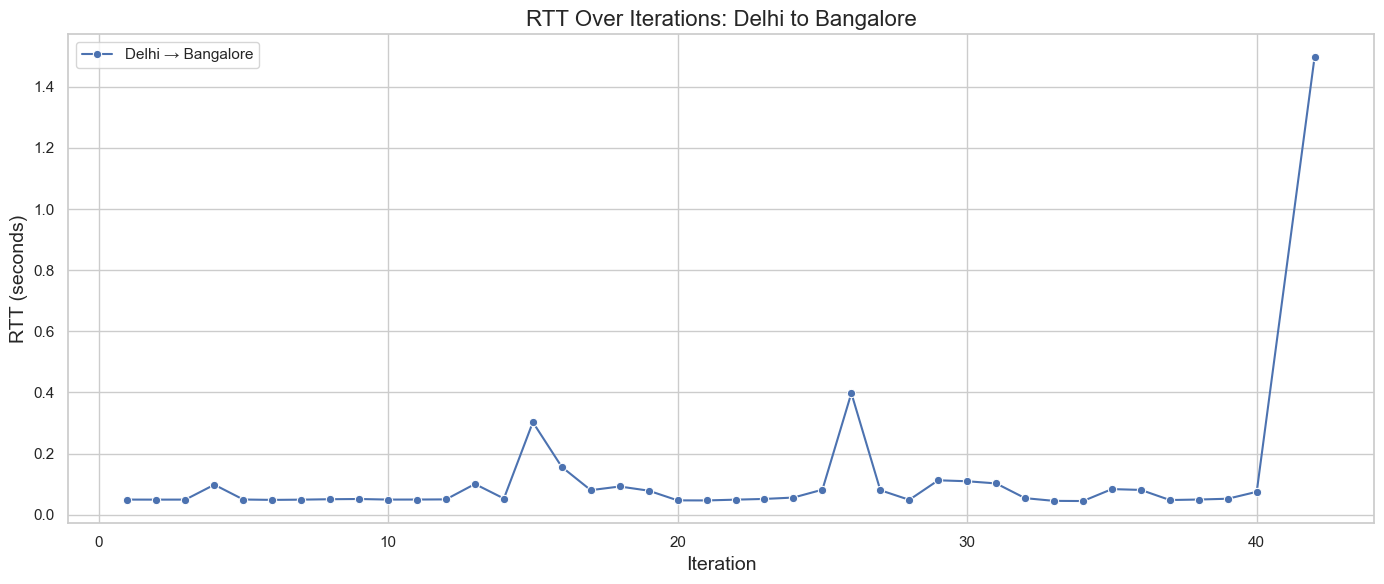

In [15]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_delhi_merged, x='Iteration', y='RTT_Bangalore', marker='o', label='Delhi → Bangalore')
plt.title('RTT Over Iterations: Delhi to Bangalore', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


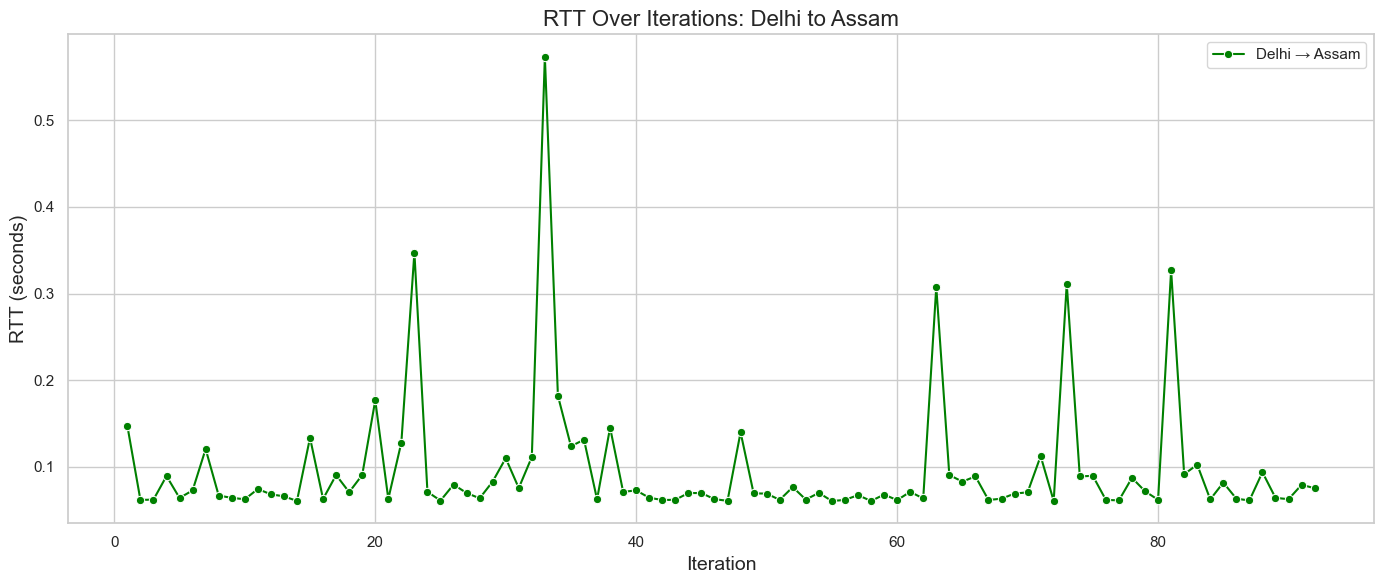

In [16]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_delhi_merged, x='Iteration', y='RTT_Assam', marker='o', color='green', label='Delhi → Assam')
plt.title('RTT Over Iterations: Delhi to Assam', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


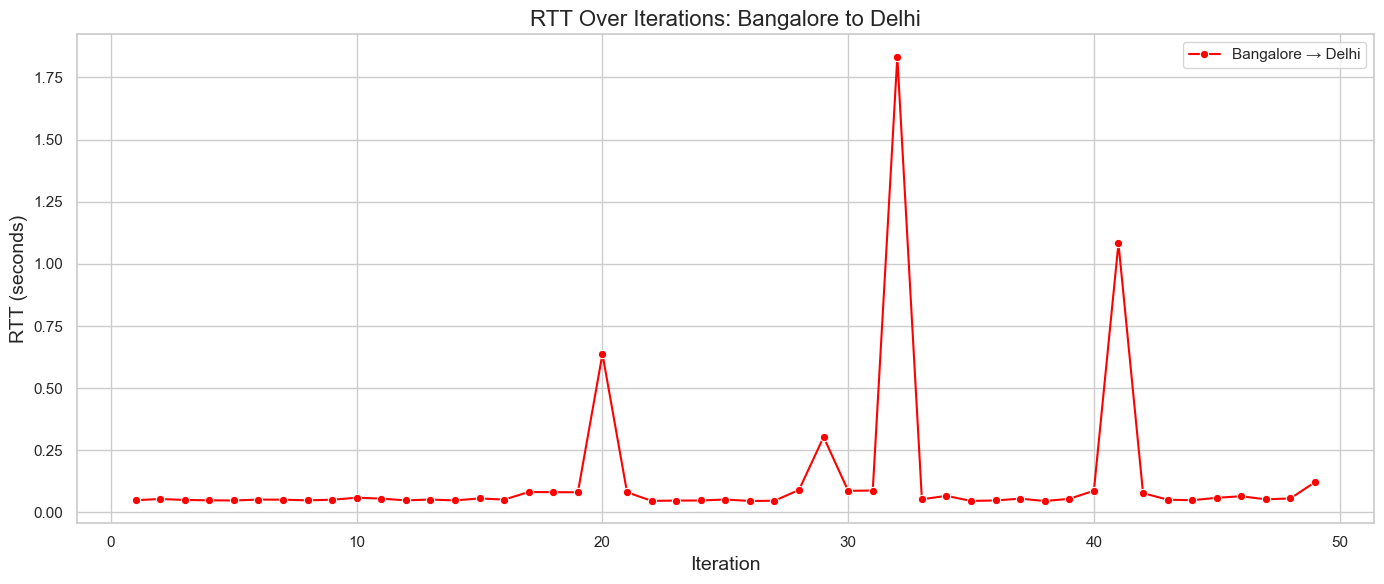

In [17]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_bangalore_merged, x='Iteration', y='RTT_Delhi', marker='o', color='red', label='Bangalore → Delhi')
plt.title('RTT Over Iterations: Bangalore to Delhi', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


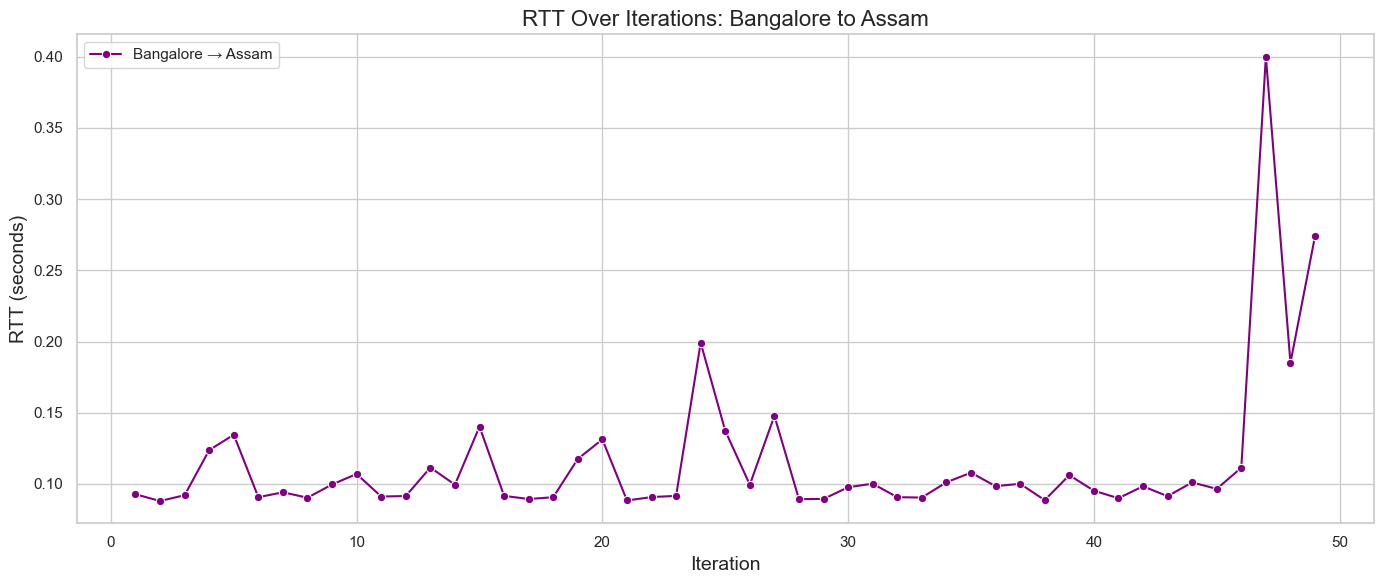

In [18]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_bangalore_merged, x='Iteration', y='RTT_Assam', marker='o', color='purple', label='Bangalore → Assam')
plt.title('RTT Over Iterations: Bangalore to Assam', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('RTT (seconds)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


delhi to jorhat- 1685Km
delhi to bangalore - 1740km
bangalore to jorhat 2308Km


Delhi Server RTT Data:
   Iteration   Verifier       RTT
0          1  Bangalore  0.049336
1          1      Assam  0.147073
2          2  Bangalore  0.049214
3          2      Assam  0.061597
4          3  Bangalore  0.049308

Bangalore Server RTT Data:
   Iteration Verifier       RTT
0          1    Delhi  0.049311
1          1    Assam  0.092780
2          2    Delhi  0.054290
3          2    Assam  0.088019
4          3    Delhi  0.050411

Delhi Server Merged RTT Data:
   Iteration Verifier_x  RTT_Bangalore Verifier_y  RTT_Assam
0          1  Bangalore       0.049336      Assam   0.147073
1          2  Bangalore       0.049214      Assam   0.061597
2          3  Bangalore       0.049308      Assam   0.061859
3          4  Bangalore       0.098027      Assam   0.089171
4          5  Bangalore       0.049575      Assam   0.063816

Bangalore Server Merged RTT Data:
   Iteration Verifier_x  RTT_Delhi Verifier_y  RTT_Assam
0          1      Delhi   0.049311      Assam   0.092780
1     

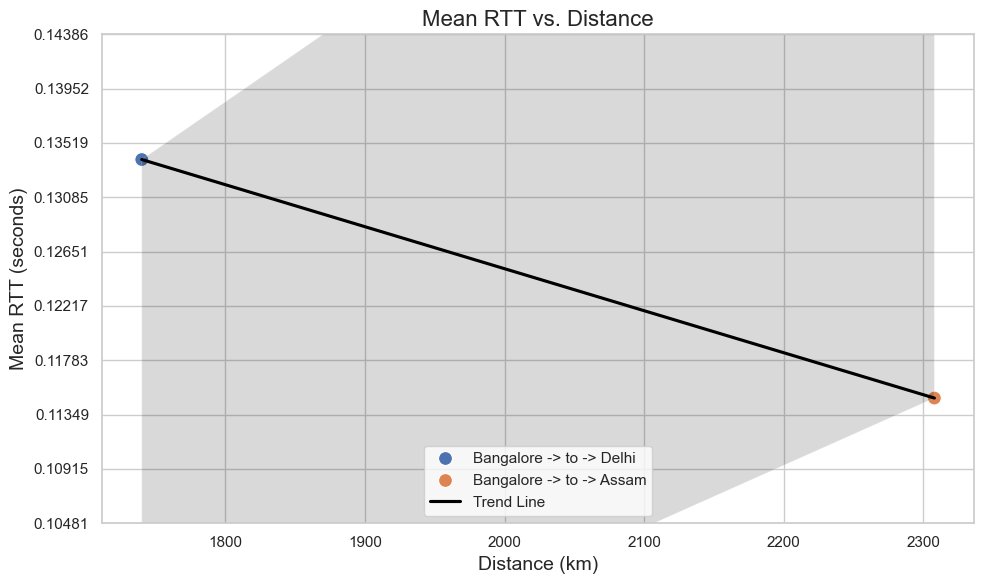


City Coordinates:
        City  Latitude  Longitude
0      Delhi   28.7041    77.1025
1  Bangalore   12.9716    77.5946
2     Jorhat   26.7525    94.8389
Skipping connection Bangalore -> Delhi due to missing RTT or distance data.
Skipping connection Bangalore -> Assam due to missing RTT or distance data.

India RTT Map has been saved as 'India_RTT_Map.html'. Please open this file in a web browser to view the interactive map.


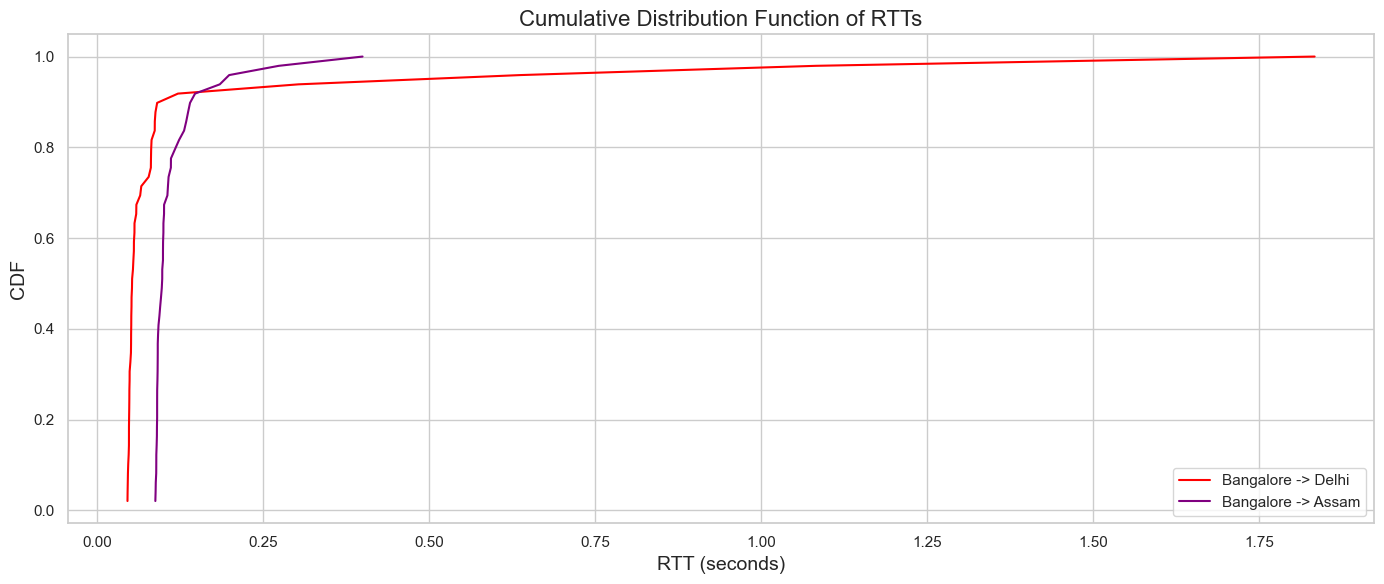

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os
import folium

# Set seaborn style
sns.set(style="whitegrid")

# Define server to region mapping
server_mapping = {
    '1': 'Bangalore',
    '2': 'Delhi',
    '3': 'Assam'
}

def parse_rtt_log(file_path):
    """
    Parses RTT log file and returns a DataFrame.

    Parameters:
    - file_path (str): Path to the RTT log file.

    Returns:
    - pd.DataFrame: Parsed RTT data with columns ['Iteration', 'Verifier', 'RTT']
    """
    iterations = []
    verifiers = []
    rtts = []

    # Define regex pattern
    pattern = r"Iteration\s+(\d+),\s+Verifier\s+server(\d+):\s+RTT=([0-9.]+)"

    # Read and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            match = re.match(pattern, line.strip())
            if match:
                iteration = int(match.group(1))
                server_num = match.group(2)
                rtt = float(match.group(3))
                verifier = server_mapping.get(server_num, f'server{server_num}').strip()
                iterations.append(iteration)
                verifiers.append(verifier)
                rtts.append(rtt)

    # Create DataFrame
    df = pd.DataFrame({
        'Iteration': iterations,
        'Verifier': verifiers,
        'RTT': rtts
    })

    return df

def create_connection_df(df, source, target):
    """
    Filters the DataFrame for a specific connection.

    Parameters:
    - df (pd.DataFrame): Original DataFrame.
    - source (str): Source region.
    - target (str): Target region.

    Returns:
    - pd.DataFrame: Filtered DataFrame for the connection.
    """
    return df[(df['Verifier'] == target)].copy().rename(columns={'RTT': f'RTT_{target}'})

def highlight_spikes(df, connection_column):
    """
    Identifies spikes and returns a DataFrame with spike indicators.

    Parameters:
    - df (pd.DataFrame): DataFrame containing RTT data.
    - connection_column (str): Column name for the connection's RTT.

    Returns:
    - pd.DataFrame: DataFrame with a 'Spike' column.
    - float: 95th percentile threshold
    """
    threshold = df[connection_column].quantile(0.95)
    df['Spike'] = df[connection_column] > threshold
    return df, threshold

def get_mean_rtt(df_summary, connection_name):
    try:
        mean_rtt = df_summary[df_summary['Connection'] == connection_name]['Mean RTT (s)'].values[0]
        return mean_rtt
    except IndexError:
        print(f"Warning: '{connection_name}' not found in df_summary.")
        return np.nan  # or any default value you prefer

def plot_rtt_with_spikes(df, connection, threshold, color, spike_color):
    """
    Plots RTT over Iterations with spikes highlighted.

    Parameters:
    - df (pd.DataFrame): DataFrame containing RTT data.
    - connection (str): Connection name for labeling.
    - threshold (float): 95th percentile threshold.
    - color (str): Line color.
    - spike_color (str): Spike marker color.
    """
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x='Iteration', y=connection, marker='o', color=color, label=connection)
    # Highlight spikes
    spikes = df[df['Spike']]
    sns.scatterplot(data=spikes, x='Iteration', y=connection, color=spike_color, label='Spike', s=100, marker='X')
    # Threshold line
    plt.axhline(y=threshold, color=spike_color, linestyle='--', label='95th Percentile')
    plt.title(f'RTT with Delay Spikes: {connection.replace("RTT_", "").replace("_", " to ")}', fontsize=16)
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('RTT (seconds)', fontsize=14)
    plt.ylim(df[connection].min() - 0.01, df[connection].max() + 0.01)  # Granular y-axis
    plt.yticks(np.linspace(df[connection].min() - 0.01, df[connection].max() + 0.01, 10))
    plt.legend()
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'RTT_{connection}.png', dpi=300)
    plt.show()

def plot_histogram(df, connection, threshold, color):
    """
    Plots histogram of RTT with 95th percentile threshold.

    Parameters:
    - df (pd.DataFrame): DataFrame containing RTT data.
    - connection (str): Connection name for labeling.
    - threshold (float): 95th percentile threshold.
    - color (str): Histogram color.
    """
    plt.figure(figsize=(14, 6))
    sns.histplot(df[connection], bins=20, kde=True, color=color, label=connection)
    plt.axvline(x=threshold, color='red', linestyle='--', label='95th Percentile')
    plt.title(f'RTT Distribution: {connection.replace("RTT_", "").replace("_", " to ")}', fontsize=16)
    plt.xlabel('RTT (seconds)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlim(df[connection].min() - 0.01, df[connection].max() + 0.01)  # Granular x-axis
    plt.xticks(np.linspace(df[connection].min() - 0.01, df[connection].max() + 0.01, 10))
    plt.legend()
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'Histogram_{connection}.png', dpi=300)
    plt.show()

def plot_boxplot(df, connection, color):
    """
    Plots boxplot for RTT.

    Parameters:
    - df (pd.DataFrame): DataFrame containing RTT data.
    - connection (str): Connection name for labeling.
    - color (str): Boxplot color.
    """
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[connection], color=color)
    plt.title(f'RTT Box Plot: {connection.replace("RTT_", "").replace("_", " to ")}', fontsize=16)
    plt.ylabel('RTT (seconds)', fontsize=14)
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'Boxplot_{connection}.png', dpi=300)
    plt.show()

def plot_cdf_all(df_delhi, df_bangalore):
    """
    Plots CDF for all connections.

    Parameters:
    - df_delhi (pd.DataFrame): Delhi server merged RTT data.
    - df_bangalore (pd.DataFrame): Bangalore server merged RTT data.
    """
    plt.figure(figsize=(14, 6))
    
    connections = {
        'Bangalore -> Delhi': df_bangalore['RTT_Delhi'],
        'Bangalore -> Assam': df_bangalore['RTT_Assam']
    }
    
    colors = {
        'Bangalore -> Delhi': 'red',
        'Bangalore -> Assam': 'purple'
    }
    
    for conn, rtts in connections.items():
        sorted_rtts = np.sort(rtts.dropna())
        cdf = np.arange(1, len(sorted_rtts)+1) / len(sorted_rtts)
        plt.plot(sorted_rtts, cdf, label=conn, color=colors[conn])
    
    plt.title('Cumulative Distribution Function of RTTs', fontsize=16)
    plt.xlabel('RTT (seconds)', fontsize=14)
    plt.ylabel('CDF', fontsize=14)
    plt.legend()
    plt.tight_layout()
    # Save the plot
    plt.savefig('CDF_RTTs.png', dpi=300)
    plt.show()

# Paths to your RTT log files
delhi_log_path = 'rtt_delhi.txt'         # Replace with your actual path
bangalore_log_path = 'rtt_bangalore.txt' # Replace with your actual path

# Check if files exist
if not os.path.isfile(delhi_log_path):
    print(f"Warning: Delhi log file not found at path: {delhi_log_path}")
if not os.path.isfile(bangalore_log_path):
    print(f"Warning: Bangalore log file not found at path: {bangalore_log_path}")

# Parse logs
if os.path.isfile(delhi_log_path):
    df_delhi = parse_rtt_log(delhi_log_path)
    print("\nDelhi Server RTT Data:")
    print(df_delhi.head())
else:
    df_delhi = pd.DataFrame(columns=['Iteration', 'Verifier', 'RTT'])
    print("\nDelhi Server RTT Data: No data available.")

if os.path.isfile(bangalore_log_path):
    df_bangalore = parse_rtt_log(bangalore_log_path)
    print("\nBangalore Server RTT Data:")
    print(df_bangalore.head())
else:
    df_bangalore = pd.DataFrame(columns=['Iteration', 'Verifier', 'RTT'])
    print("\nBangalore Server RTT Data: No data available.")

# Create connection-specific DataFrames
if not df_delhi.empty:
    delhi_to_bangalore = create_connection_df(df_delhi, 'Delhi', 'Bangalore')
    delhi_to_assam = create_connection_df(df_delhi, 'Delhi', 'Assam')
    # Merge DataFrames based on Iteration
    df_delhi_merged = pd.merge(delhi_to_bangalore, delhi_to_assam, on='Iteration', how='outer').sort_values('Iteration')
    print("\nDelhi Server Merged RTT Data:")
    print(df_delhi_merged.head())
else:
    df_delhi_merged = pd.DataFrame(columns=['Iteration', 'RTT_Bangalore', 'RTT_Assam'])
    print("\nDelhi Server Merged RTT Data: No data available.")

if not df_bangalore.empty:
    bangalore_to_delhi = create_connection_df(df_bangalore, 'Bangalore', 'Delhi')
    bangalore_to_assam = create_connection_df(df_bangalore, 'Bangalore', 'Assam')
    # Merge DataFrames based on Iteration
    df_bangalore_merged = pd.merge(bangalore_to_delhi, bangalore_to_assam, on='Iteration', how='outer').sort_values('Iteration')
    print("\nBangalore Server Merged RTT Data:")
    print(df_bangalore_merged.head())
else:
    df_bangalore_merged = pd.DataFrame(columns=['Iteration', 'RTT_Delhi', 'RTT_Assam'])
    print("\nBangalore Server Merged RTT Data: No data available.")

# Calculate mean and median RTTs for existing connections
connections = {
    'Bangalore_to_Delhi': {
        'df': df_bangalore_merged,
        'RTT_column': 'RTT_Delhi',
        'distance_km': 1740
    },
    'Bangalore_to_Assam': {
        'df': df_bangalore_merged,
        'RTT_column': 'RTT_Assam',
        'distance_km': 2308
    }
}

# Initialize list to store summary
summary_data = []

for conn_name, details in connections.items():
    df_conn = details['df']
    rtt_col = details['RTT_column']
    distance = details['distance_km']
    
    if rtt_col in df_conn.columns and not df_conn[rtt_col].isnull().all():
        mean_rtt = df_conn[rtt_col].mean()
        median_rtt = df_conn[rtt_col].median()
    else:
        mean_rtt = np.nan
        median_rtt = np.nan
    
    summary_data.append({
        'Connection': conn_name.replace('_', ' -> '),  # Use '->' consistently
        'Distance (km)': distance,
        'Mean RTT (s)': mean_rtt,
        'Median RTT (s)': median_rtt
    })

# Create summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nSummary of RTTs and Distances:")
print(df_summary)

# Normalize distances using Min-Max Normalization
distances = df_summary['Distance (km)']
df_summary['Normalized_Distance'] = (distances - distances.min()) / (distances.max() - distances.min())

print("\nNormalized Distances:")
print(df_summary[['Connection', 'Distance (km)', 'Normalized_Distance']])

# Calculate Pearson correlation coefficient
if len(df_summary.dropna()) >= 2:
    correlation_mean = df_summary['Distance (km)'].corr(df_summary['Mean RTT (s)'])
    correlation_median = df_summary['Distance (km)'].corr(df_summary['Median RTT (s)'])
    print(f"\nPearson Correlation between Distance and Mean RTT: {correlation_mean:.4f}")
    print(f"Pearson Correlation between Distance and Median RTT: {correlation_median:.4f}")
else:
    print("\nNot enough data to calculate Pearson Correlation.")

# Scatter plot for Mean RTT vs Distance
if not df_summary.empty and 'Mean RTT (s)' in df_summary.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_summary, x='Distance (km)', y='Mean RTT (s)', hue='Connection', s=100)
    sns.regplot(data=df_summary, x='Distance (km)', y='Mean RTT (s)', scatter=False, color='black', label='Trend Line')
    plt.title('Mean RTT vs. Distance', fontsize=16)
    plt.xlabel('Distance (km)', fontsize=14)
    plt.ylabel('Mean RTT (seconds)', fontsize=14)
    plt.ylim(df_summary['Mean RTT (s)'].min() - 0.01, df_summary['Mean RTT (s)'].max() + 0.01)  # Granular y-axis
    plt.yticks(np.linspace(df_summary['Mean RTT (s)'].min() - 0.01, df_summary['Mean RTT (s)'].max() + 0.01, 10))
    plt.legend()
    plt.tight_layout()
    plt.savefig('Mean_RTT_vs_Distance.png', dpi=300)
    plt.show()
else:
    print("\nMean RTT data not available for plotting.")

# Define geographic coordinates for each city
cities = {
    'Delhi': {'lat': 28.7041, 'lon': 77.1025},
    'Bangalore': {'lat': 12.9716, 'lon': 77.5946},
    'Jorhat': {'lat': 26.7525, 'lon': 94.8389}
}

# Create a DataFrame for cities
df_cities = pd.DataFrame([
    {'City': city, 'Latitude': info['lat'], 'Longitude': info['lon']}
    for city, info in cities.items()
])
print("\nCity Coordinates:")
print(df_cities)

# Initialize the map centered around India
india_map = folium.Map(location=[22.5937, 78.9629], zoom_start=5)

# Add city markers
for _, row in df_cities.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['City'],
        tooltip=row['City'],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(india_map)

# Define connections with RTT annotations
connections_with_rtt = [
    {
        'source': 'Bangalore',
        'target': 'Delhi',
        'Distance_km': 1740,
        'Mean_RTT_s': get_mean_rtt(df_summary, 'Bangalore -> Delhi'),
        'Normalized_Distance': df_summary[df_summary['Connection'] == 'Bangalore -> Delhi']['Normalized_Distance'].values[0] if 'Bangalore -> Delhi' in df_summary['Connection'].values else np.nan
    },
    {
        'source': 'Bangalore',
        'target': 'Assam',
        'Distance_km': 2308,
        'Mean_RTT_s': get_mean_rtt(df_summary, 'Bangalore -> Assam'),
        'Normalized_Distance': df_summary[df_summary['Connection'] == 'Bangalore -> Assam']['Normalized_Distance'].values[0] if 'Bangalore -> Assam' in df_summary['Connection'].values else np.nan
    }
]

# Add lines and RTT annotations
for conn in connections_with_rtt:
    source = conn['source']
    target = conn['target']
    rtt = conn['Mean_RTT_s']
    norm_dist = conn['Normalized_Distance']
    
    if np.isnan(rtt) or np.isnan(norm_dist):
        print(f"Skipping connection {source} -> {target} due to missing RTT or distance data.")
        continue
    
    # Get coordinates
    source_coord = df_cities[df_cities['City'] == source][['Latitude', 'Longitude']].values[0]
    target_coord = df_cities[df_cities['City'] == target][['Latitude', 'Longitude']].values[0]
    
    # Determine line thickness based on normalized distance
    # For visualization: minimum thickness =2, maximum thickness=8
    line_thickness = 2 + norm_dist * 6  # 2 + 6 = 8
    
    # Choose color based on RTT (optional): e.g., higher RTT = red, lower = green
    # Here, we use a gradient from green (low RTT) to red (high RTT)
    # Normalize RTT for color mapping
    max_rtt = df_summary['Mean RTT (s)'].max()
    min_rtt = df_summary['Mean RTT (s)'].min()
    if max_rtt != min_rtt:
        normalized_rtt = (rtt - min_rtt) / (max_rtt - min_rtt)
    else:
        normalized_rtt = 0
    # Convert to RGB color (green to red)
    r = int(normalized_rtt * 255)
    g = int((1 - normalized_rtt) * 255)
    b = 0
    line_color = f'#{r:02x}{g:02x}{b:02x}'
    
    # Add a line between source and target
    folium.PolyLine(
        locations=[source_coord, target_coord],
        color=line_color,
        weight=line_thickness,
        opacity=0.8
    ).add_to(india_map)
    
    # Calculate midpoint for annotation
    midpoint = [(source_coord[0] + target_coord[0])/2, (source_coord[1] + target_coord[1])/2]
    
    # Add RTT annotation with color based on RTT
    folium.Marker(
        location=midpoint,
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12pt; color : black"><b>RTT: {rtt:.3f} s</b></div>"""
        )
    ).add_to(india_map)

# Save and display the map
india_map.save('India_RTT_Map.html')
print("\nIndia RTT Map has been saved as 'India_RTT_Map.html'. Please open this file in a web browser to view the interactive map.")

# Plot CDF for all connections
if not df_bangalore_merged.empty and ('RTT_Delhi' in df_bangalore_merged.columns or 'RTT_Assam' in df_bangalore_merged.columns):
    plot_cdf_all(df_delhi_merged, df_bangalore_merged)
else:
    print("\nCDF Plot: Not enough data available.")
